[[0.01705009 0.5314896  0.05011377 0.52133655]
 [0.28825932 0.22458204 0.34978641 0.33532637]
 [0.23109598 0.54374427 0.56763091 0.17354539]]


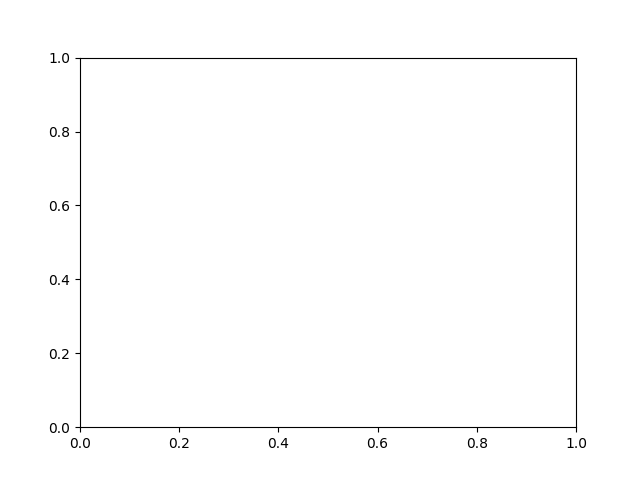

In [1]:
%matplotlib widget
import matplotlib
import numpy as np

def create_random_matrix(n, m):
    """
    Creates a matrix of random values between 0 and 1 of size n x m.

    Parameters:
    - n: Number of rows
    - m: Number of columns

    Returns:
    - A numpy array representing the random matrix
    """
    random_matrix = np.random.rand(n, m)
    return random_matrix


# Example usage:
n = 3  # number of rows
m = 4  # number of columns
random_matrix = create_random_matrix(n, m)
print(random_matrix)
pixel_series = [create_random_matrix(5, 7) * 255 for _ in range(10)]  # Example: non-smoothed pixel series

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

fig, ax = plt.subplots()


def update(frame):
    ax.clear()
    ax.imshow(pixel_series[frame], cmap='gray', interpolation='nearest', aspect='auto')
    ax.set_title(f"Frame {frame + 1}/{len(pixel_series)}")


animation = FuncAnimation(fig, update, frames=len(pixel_series), interval=200, repeat=False)

plt.show()  # Add block=False to allow the program to continue

# Example usage:
# Assuming you have a list of matrices representing pixel values

# Plot the series of pixel matrices with a grayscale colormap
